# HOG Examples

To experiment with HOG, we will be modifying the `cell_size`, `num_cells_per_block`, and `num_bins` (the number of angular bins in the histograms), to see how these parameters affect the resulting HOG descriptor. It will help to get some intuition for what each parameter does and how they can be *tuned* to pick out the amount of detail required. The list of the available images that can loaded is as following:

* cat.jpeg
* jeep1.jpeg
* jeep2.jpeg
* jeep3.jpeg
* man.jpeg
* pedestrian_bike.jpeg
* roundabout.jpeg
* scrabble.jpeg
* shuttle.jpeg
* triangle_tile.jpeg
* watch.jpeg
* woman.jpeg

### Importing the Libraries

In [11]:
import cv2
import copy
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib notebook

### Loading the Image

In [12]:
# Loading the image 
image = cv2.imread('./images/scrabble.jpeg')

# Converting the original image to RGB
original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Converting the original image to gray scale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Printing the shape of the gray scale image for reference
print('The gray scale image has shape: ', gray_image.shape)

The gray scale image has shape:  (426, 640)


<IPython.core.display.Javascript object>


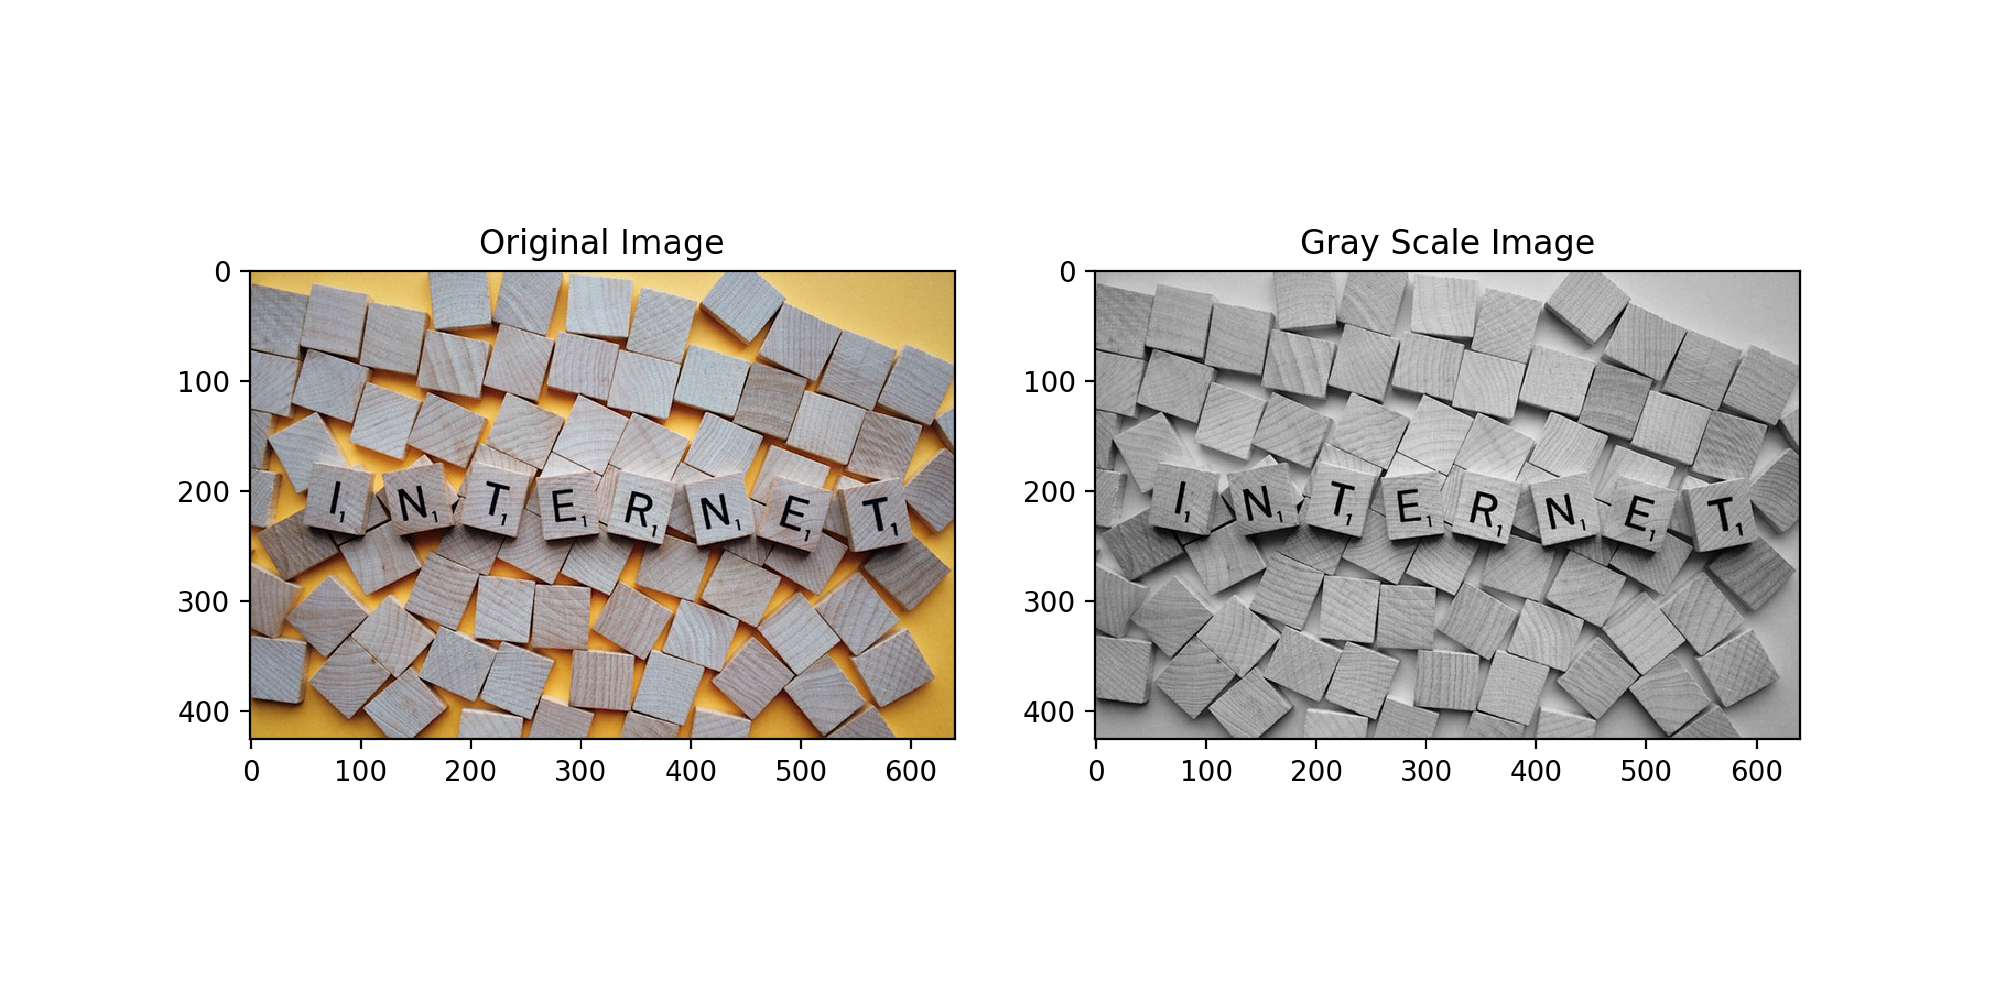

In [14]:
# Setting the default figure size
plt.rcParams['figure.figsize'] = [10, 5]

# Displaying the images
plt.subplot(121)
plt.imshow(original_image)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(gray_image, cmap='gray')
plt.title('Gray Scale Image')
plt.show()

### Setting up the HOG Descriptor

#### Defining the Parameters

In [4]:
# Cell Size in pixels (width, height)
# Must be chosen so that the resulting Block Size is smaller than the detection window
cell_size = (8, 8)

# Number of cells per block in each direction (x, y)
num_cells_per_block = (2, 2)

# Number of gradient orientation bins
num_bins = 9

In [15]:
# Block Size in pixels (width, height)
block_size = (num_cells_per_block[0] * cell_size[0],
              num_cells_per_block[1] * cell_size[1])

# Calculating the number of cells that fit in our image in the x and y directions
x_cells = gray_image.shape[1] // cell_size[0]
y_cells = gray_image.shape[0] // cell_size[1]

In [16]:
# Horizontal and Vertical distance between blocks in units of Cell Size
# Such that (x_cells - num_cells_per_block[0]) / h_stride = integer 
# or (y_cells - num_cells_per_block[1]) / v_stride = integer.
h_stride = 1
v_stride = 1

# Block Stride in pixels (horizantal, vertical)
block_stride = (cell_size[0] * h_stride, cell_size[1] * v_stride)

# Specifing size of detection window (Region of Interest) in pixels (width, height)
# The resulting detection window might be slightly smaller than the image
win_size = (x_cells * cell_size[0] , y_cells * cell_size[1])

# Printing the parameters of our HOG descriptor
print('HOG Descriptor Parameters:')
print('\tWindow Size:', win_size)
print('\tCell Size:', cell_size)
print('\tBlock Size:', block_size)
print('\tBlock Stride:', block_stride)
print('\tNumber of Bins:', num_bins)

HOG Descriptor Parameters:
	Window Size: (640, 424)
	Cell Size: (8, 8)
	Block Size: (16, 16)
	Block Stride: (8, 8)
	Number of Bins: 9


#### Computing the HOG Descriptor

In [17]:
# Set the parameters of the HOG descriptor using the variables defined above
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

# Compute the HOG Descriptor for the gray scale image
hog_descriptor = hog.compute(gray_image)

### Plotting the HOG Descriptor

#### Rearranging the HOG Descriptor

In [18]:
# Calculating total number of blocks along the width and height of the detection window
tot_bx = np.uint32(((x_cells - num_cells_per_block[0]) / h_stride) + 1)
tot_by = np.uint32(((y_cells - num_cells_per_block[1]) / v_stride) + 1)

# Calculate the total number of elements in the feature vector
tot_els = (tot_bx) * (tot_by) * num_cells_per_block[0] * num_cells_per_block[1] * num_bins

# Reshaping the feature vector to [blocks_y, blocks_x, num_cells_per_block_x, num_cells_per_block_y, num_bins].
# blocks_x(column) and blocks_y(row) is transposed so that the feature vector indexing matches the image indexing.
hog_descriptor_reshaped = hog_descriptor.reshape(tot_bx,
                                                 tot_by,
                                                 num_cells_per_block[0],
                                                 num_cells_per_block[1],
                                                 num_bins).transpose((1, 0, 2, 3, 4))

In [19]:
# Creating an array that will hold the average gradients for each cell
ave_grad = np.zeros((y_cells, x_cells, num_bins))

# Creating an array that will count the number of histograms per cell
hist_counter = np.zeros((y_cells, x_cells, 1))

# Adding up all the histograms for each cell and counting the number of histograms per cell
for i in range (num_cells_per_block[0]):
    for j in range(num_cells_per_block[1]):
        ave_grad[i:tot_by + i,
                 j:tot_bx + j] += hog_descriptor_reshaped[:, :, i, j, :]
        
        hist_counter[i:tot_by + i,
                     j:tot_bx + j] += 1

# Calculating the average gradient for each cell
ave_grad /= hist_counter
   
# Calculating the total number of vectors in all the cells
len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

# Create an array that has num_bins equally spaced between 0 and 180 degress in radians
deg = np.linspace(0, np.pi, num_bins, endpoint = False)

# Creating rank 1 arrays to hold the (x,y)-coordinate of all the vectors in all the cells in the image
# Creating rank 1 arrays to hold the (U,V)-components of all the vectors in all the cells in the image
U = np.zeros((len_vecs))
V = np.zeros((len_vecs))
X = np.zeros((len_vecs))
Y = np.zeros((len_vecs))

# Set the counter to zero
counter = 0

# Using cosine and sine functions to calculate (U,V) from their maginitudes
for i in range(ave_grad.shape[0]):
    for j in range(ave_grad.shape[1]):
        for k in range(ave_grad.shape[2]):
            U[counter] = ave_grad[i,j,k] * np.cos(deg[k])
            V[counter] = ave_grad[i,j,k] * np.sin(deg[k])
        
            X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
            Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)
        
            counter = counter + 1

#### Displaying the results

<IPython.core.display.Javascript object>


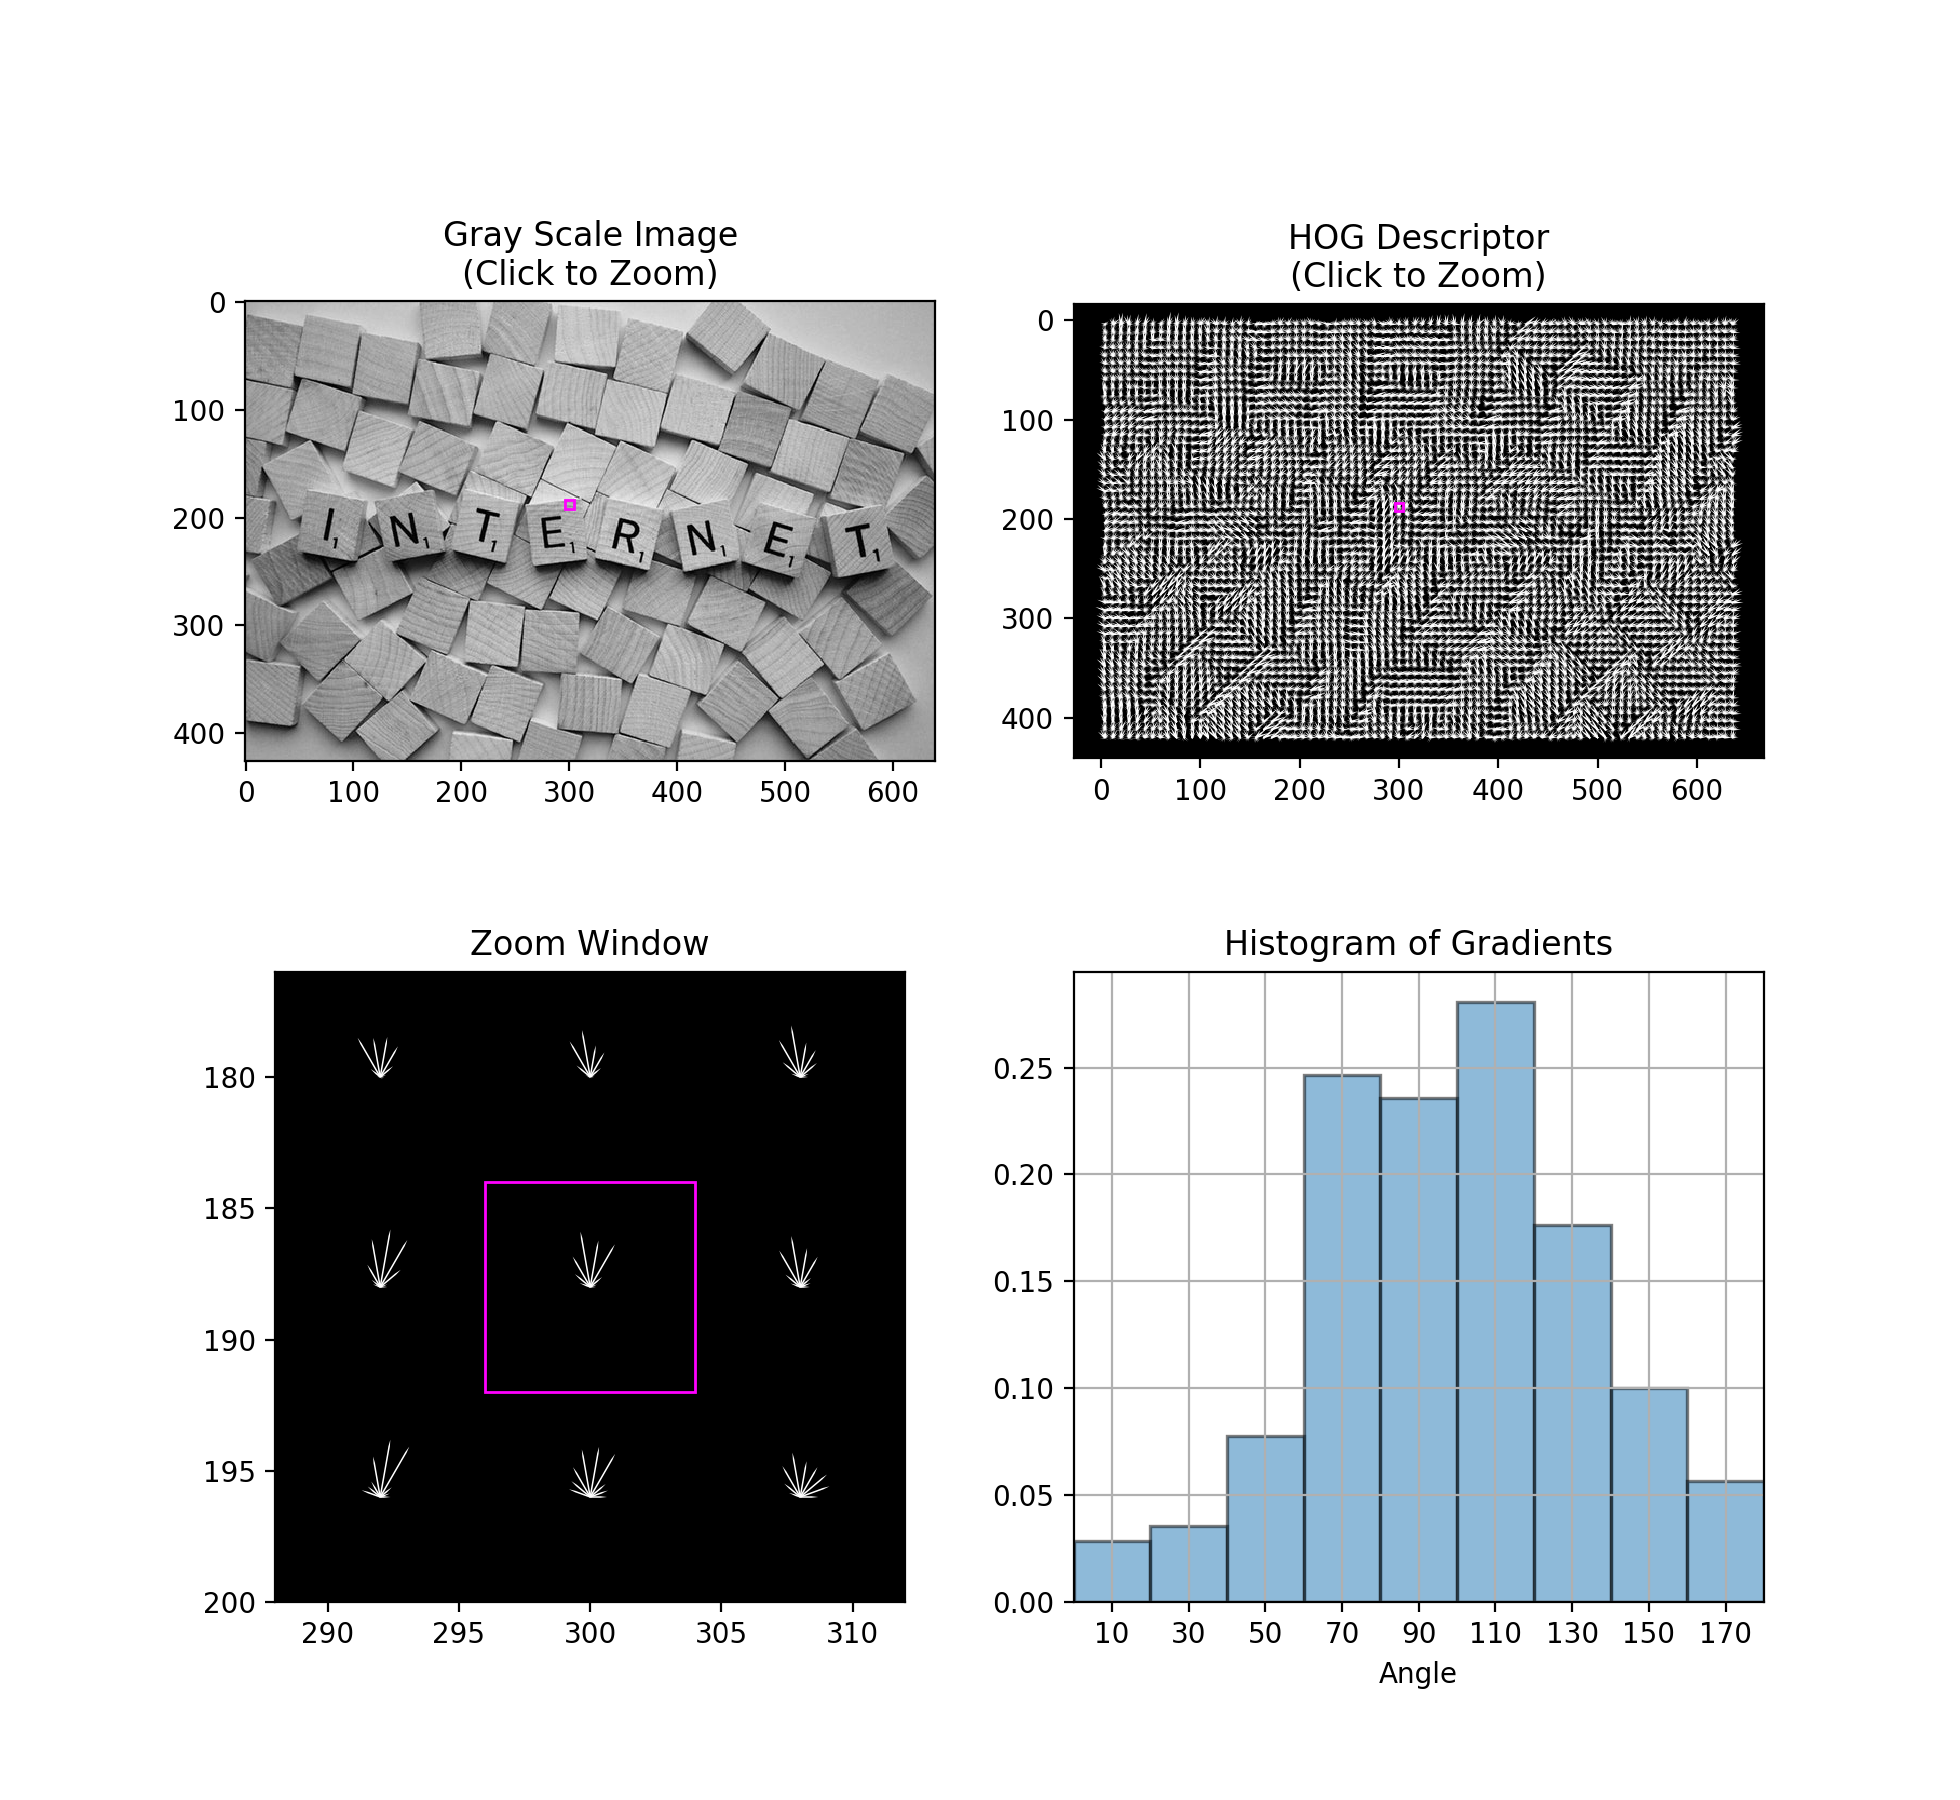

In [20]:
# Setting the default figure size
plt.rcParams['figure.figsize'] = [9.8, 9]

# Creating a figure with 4 subplots arranged in 2 x 2
fig, ((a,b),(c,d)) = plt.subplots(2,2)

# Setting the title of each subplot
a.set(title = 'Gray Scale Image\n(Click to Zoom)')
b.set(title = 'HOG Descriptor\n(Click to Zoom)')
c.set(title = 'Zoom Window', xlim = (0, 18), ylim = (0, 18), autoscale_on = False)
d.set(title = 'Histogram of Gradients')

# Creating the bins in degress to plot our histogram. 
angle_axis = np.linspace(0, 180, num_bins, endpoint = False)
angle_axis += ((angle_axis[1] - angle_axis[0]) / 2)

# Plotting the gray scale image
a.imshow(gray_image, cmap = 'gray')
a.set_aspect(aspect = 1)

# Plotting the feature vector (HOG Descriptor)
b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
b.invert_yaxis()
b.set_aspect(aspect = 1)
b.set_facecolor('black')

# Defining function for interactive zoom
def onpress(event):
    
    # Unless the left mouse button is pressed do nothing
    if event.button != 1:
        return
    
    # Only accept clicks for subplots a and b
    if event.inaxes in [a, b]:
        
        # Get mouse click coordinates
        x, y = event.xdata, event.ydata
        
        # Select the cell closest to the mouse click coordinates
        cell_num_x = np.uint32(x / cell_size[0])
        cell_num_y = np.uint32(y / cell_size[1])
        
        # Set the edge coordinates of the rectangle patch
        edgex = x - (x % cell_size[0])
        edgey = y - (y % cell_size[1])
        
        # Creating a rectangle patch that matches the the cell selected above        
        rect = patches.Rectangle((edgex, edgey),
                                  cell_size[0], cell_size[1],
                                  linewidth = 1,
                                  edgecolor = 'magenta',
                                  facecolor='none')
        
        # Creating copies of the patch to use in the other subplots
        rect2 = copy.copy(rect)
        rect3 = copy.copy(rect)
        
        # Updating all subplots
        a.clear()
        a.set(title = 'Gray Scale Image\n(Click to Zoom)')
        a.imshow(gray_image, cmap = 'gray')
        a.set_aspect(aspect = 1)
        a.add_patch(rect)

        b.clear()
        b.set(title = 'HOG Descriptor\n(Click to Zoom)')
        b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
        b.invert_yaxis()
        b.set_aspect(aspect = 1)
        b.set_facecolor('black')
        b.add_patch(rect2)

        c.clear()
        c.set(title = 'Zoom Window')
        c.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 1)
        c.set_xlim(edgex - cell_size[0], edgex + (2 * cell_size[0]))
        c.set_ylim(edgey - cell_size[1], edgey + (2 * cell_size[1]))
        c.invert_yaxis()
        c.set_aspect(aspect = 1)
        c.set_facecolor('black')
        c.add_patch(rect3)

        d.clear()
        d.set(title = 'Histogram of Gradients')
        d.grid()
        d.set_xlim(0, 180)
        d.set_xticks(angle_axis)
        d.set_xlabel('Angle')
        d.bar(angle_axis,
              ave_grad[cell_num_y, cell_num_x, :],
              180 // num_bins,
              align = 'center',
              alpha = 0.5,
              linewidth = 1.2,
              edgecolor = 'k')

        fig.canvas.draw()

# Creating a connection between the figure and the mouse click
fig.canvas.mpl_connect('button_press_event', onpress)
plt.show()